In [1]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

In [44]:
# HYPERPARAMETERS
BATCH_SIZE = 64
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 35

In [45]:
# PREPROCESSING CODE

def preprocess(sent, exclude, sp_tokens=False):
    '''
    PARAMETERS
    ----------
    sent (str): sentence to preprocess
    exclude (str): characters to exclude (like punctuations)
    sp_tokens (bool): If True, special tokens '<start>' and '<end>'
                      will be added. Default False.
    '''
    
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    
    return sent


class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

            
def max_length(tensor):
    return max(len(t) for t in tensor)


def data_loader(path, batch_size, samples=None, max_len=None, reverse=False):
    '''
    PARAMTERS
    ---------
    path: path to the translation file
    
    '''
    
    # loading the dataset
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    lines = [l.split('\t')[:-1] for l in lines]
    
    if samples:
        random.shuffle(lines)
        lines = lines[:samples]
    
    if reverse:
        lines = [l[::-1] for l in lines]
        
    exclude = set(string.punctuation)
    
    # preprocessing
    prep_lines = [
        [preprocess(i, exclude, sp_tokens=False), 
         preprocess(j, exclude, sp_tokens=True)]
        for i, j in lines
    ]
    
    # Language index (vocab, idx2word, word2idx)
    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)
    
    # creating input and target tensor
    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')] 
                    for inp, tgt in prep_lines]
    
    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')] 
                     for inp, tgt in prep_lines]
    
    
    # calculating max length for padding
    if max_len:
        new_input_tensor = []
        new_target_tensor = []
        for i, j in zip(input_tensor, target_tensor):
            if (len(i) <= max_len) and (len(j) <= max_len):
                new_input_tensor.append(i)
                new_target_tensor.append(j)

        input_tensor = new_input_tensor
        target_tensor = new_target_tensor
        max_length_inp = max_length_tgt = max_len

    else:
        max_length_inp, max_length_tgt = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        input_tensor, 
        maxlen=max_length_inp,
        padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(
        target_tensor, 
        maxlen=max_length_tgt, 
        padding='post')

    (input_tensor_train, 
     input_tensor_val, 
     target_tensor_train, 
     target_tensor_val) = train_test_split(
         input_tensor, 
         target_tensor, 
         test_size=0.1, 
         random_state=42)
    
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_train, target_tensor_train)
        ).shuffle(len(input_tensor_train)).batch(batch_size, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor_val, target_tensor_val)
        ).shuffle(len(input_tensor_val)).batch(batch_size, drop_remainder=True)
    
    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt

In [46]:
# LOAD DATASET

dataset_path = 'urd.txt' 
# CHANGE `dataset_path` TO WHATEVER LANGUAGE YOU WANT
# There are total 81 languages available in the dataset 


train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(
    dataset_path, BATCH_SIZE)

In [47]:
# We have two vocabularies one of english (vocab_inp_size) and the second is what you choose
# which is urdu in my case so it is vocab_tgt_size
vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)
print(vocab_inp_size )
print(vocab_tgt_size)

1334
1718


In [48]:
# Detokenize: tokens to string
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

In [49]:
eng, ur = next(iter(train_dataset))
print('Shape:', eng.shape, ur.shape)
print('English Sentence:', detokenize(eng[0], inp_lang.idx2word))
print('Urdu Sentence: ', detokenize(ur[0], tgt_lang.idx2word))

Shape: (64, 18) (64, 23)
English Sentence: this is a daily newspaper
Urdu Sentence:  یہ اخبار روزنامہ ہے۔


## **Creating Model Architecure**
The encoder encode the English sentence and generates a `context_vector` which is used by decoder to decode the target phrase in urdu! 

In [34]:
# Encoder
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
    
    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x) # => (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]

In [35]:
# Testing if Encoder works:
tmp_enc_outputs, tmp_enc_state = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(eng)

print(tmp_enc_outputs.shape, tmp_enc_state[-1].shape)

(64, 18, 50) (64, 50)


### **Attention Mechanism**


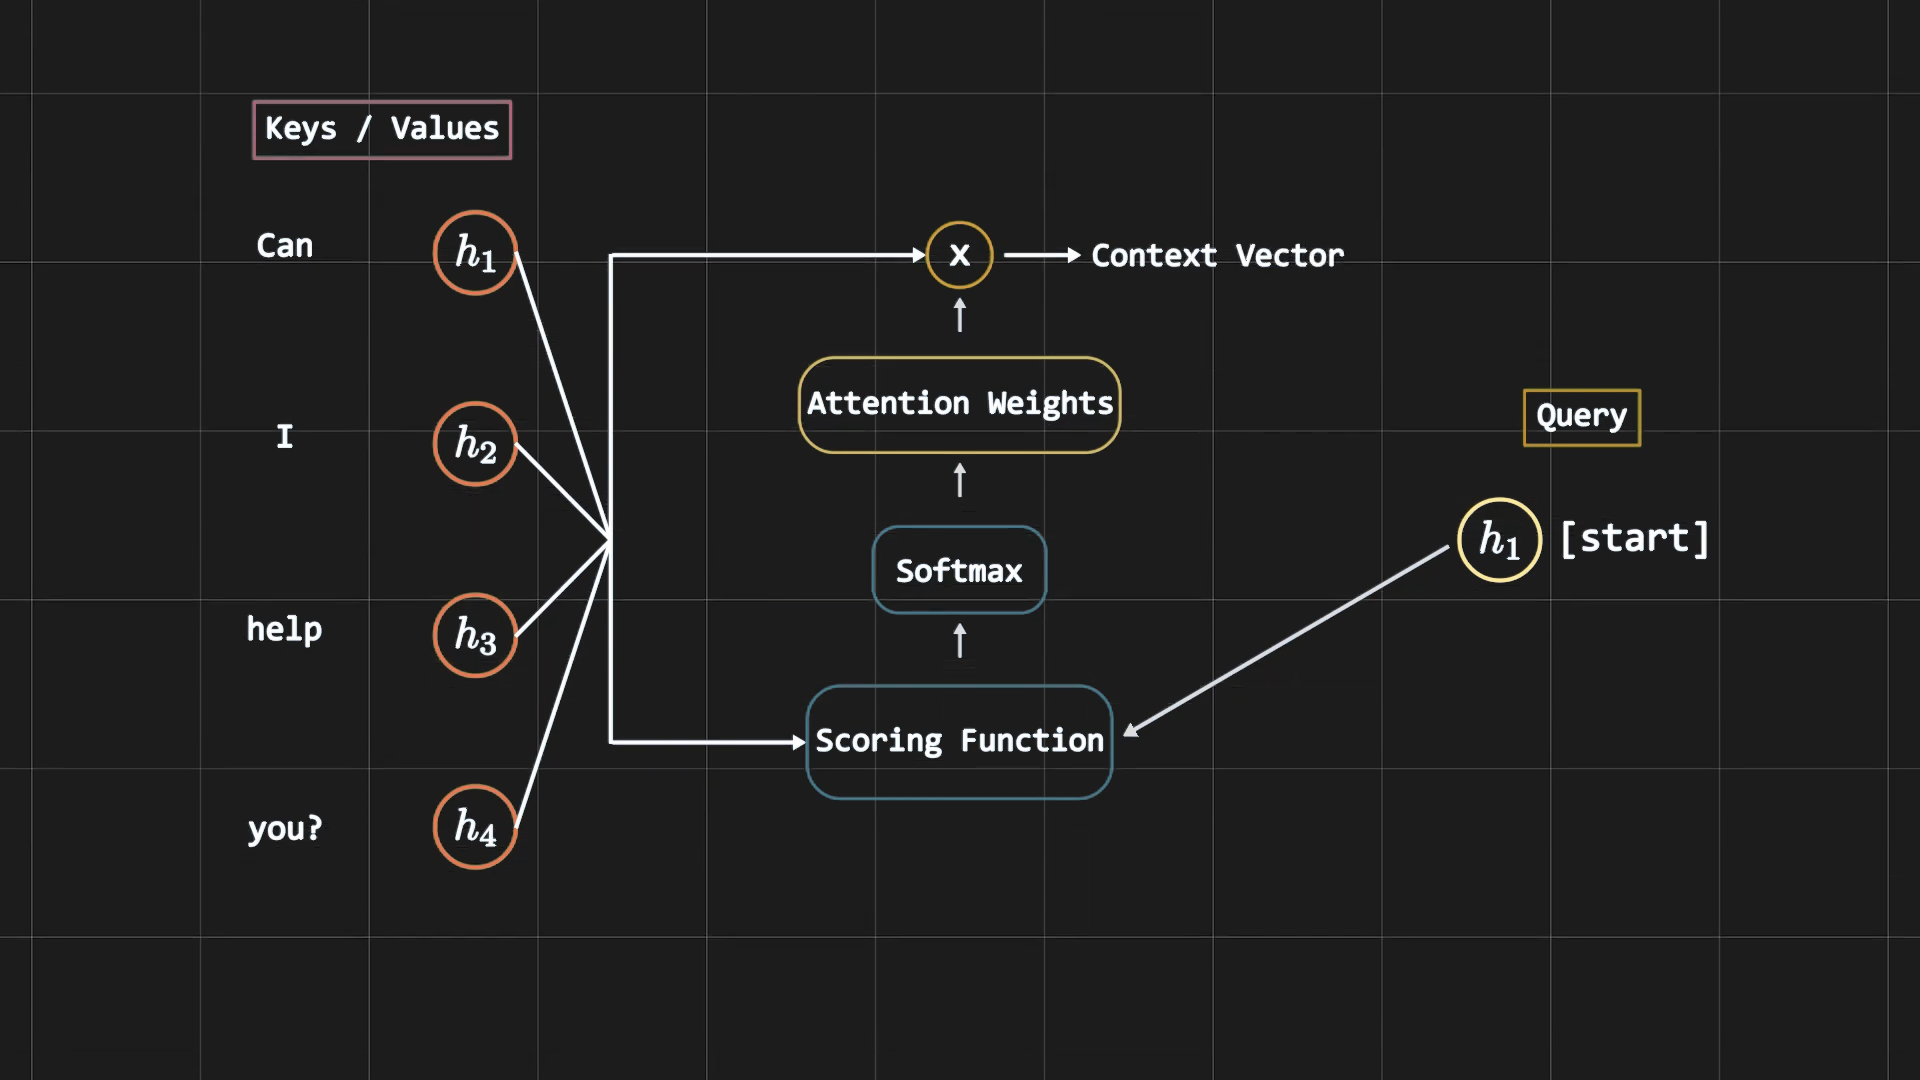

This is a rough sketch of how Attention Mechanism works. 

In [50]:
# Additive Attention:

class AdditiveAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)
    

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)
        
        if mask is not None:
            score = tf.where(mask, score, -1e6)
        
        attention_weights = tf.nn.softmax(score, axis=-1)
        # attention_weights => (batch_size, t, s)

        context = tf.matmul(attention_weights, value)
        # context => (batch_size, t, units)

        return context, attention_weights

In [51]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        
        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
        
        # Attention layer
        self.attention = AdditiveAttention(units)

        # Final layer to output logits, we can use 
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)
    

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units) 
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)
        
        return pred, state, attention_weights

In [55]:
# Testing if decoder works:

tmp_dec_output, tmp_dec_state, tmp_att_wghts = Decoder(
    EMBEDDING_DIM, UNITS, vocab_tgt_size
)(ur, tmp_enc_outputs, tmp_enc_state)

print(
    tmp_dec_output.shape, 
    tmp_dec_state[-1].shape, 
    tmp_att_wghts.shape
)

C:\Users\ASIM\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'additive_attention_8' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 23, 1718) (64, 50) (64, 23, 18)


In [56]:
# Creating instances of encoder and decoder
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

In [57]:
# Custom loss function:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [58]:
# optimizer:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [59]:
# This will store loss function value at each epoch 
# so we can plot it later
history = {
    'loss': []
}

In [21]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)
            
            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs, 
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)
                    
                loss = loss/tf.reduce_sum(tgt_mask)
            
            variables = (encoder.trainable_variables + 
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)
        
    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\ASIM\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'additive_attention_1' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch: 0 | Loss: 5.761892259120941


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | Loss: 4.81921112537384


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 | Loss: 4.497117906808853


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 | Loss: 4.249002367258072


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 | Loss: 4.015832141041756


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 | Loss: 3.7847300618886948


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 | Loss: 3.57087379693985


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 | Loss: 3.3354697823524475


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 | Loss: 3.090475380420685


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 | Loss: 2.82321260869503


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Loss: 2.5363530963659286


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Loss: 2.2584523260593414


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Loss: 1.9868824779987335


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Loss: 1.723108895123005


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Loss: 1.4895439371466637


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Loss: 1.2712560892105103


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 | Loss: 1.0872890129685402


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 | Loss: 0.9312243461608887


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 | Loss: 0.7986306399106979


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 | Loss: 0.6858957931399345


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 | Loss: 0.5904295686632395


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 | Loss: 0.5119280889630318


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 | Loss: 0.446724122390151


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 | Loss: 0.39430942945182323


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 | Loss: 0.34122560545802116


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 | Loss: 0.2958359280601144


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 | Loss: 0.2634333809837699


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 | Loss: 0.23197724763303995


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 | Loss: 0.21077462658286095


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 | Loss: 0.18785192538052797


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 | Loss: 0.17566826473921537


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 | Loss: 0.1612744266167283


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 | Loss: 0.15070938505232334


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 | Loss: 0.14073144691064954


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 | Loss: 0.1367555232718587


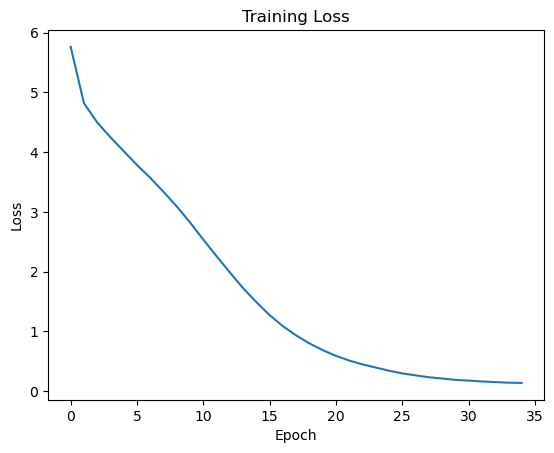

In [22]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [60]:
# Predict on new sentences:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state
    
    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))
        
    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

In [61]:
eng, ur = next(iter(train_dataset))

In [62]:
idx = -6
actual_seq = detokenize(ur[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

C:\Users\ASIM\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'additive_attention_9' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


English Sentence:      turn off the light
Predicted Translation: کال دیکھتا تمباکونوشی بجلی بجلی وکیل قبول بولتا تمباکونوشی اونچی تمباکونوشی اونچی رونے تمباکونوشی اونچی کھلی محنت افسوس تھوڑی دیکھتا تیس کھیل میری
Actual Translation:    روشنی کو بند کر دو۔
